## !! The final result should be only a runnable .py file !!

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import pickle
from torch.utils.data import random_split
from models import customized_cnn as m # our model
from training_early_stop import EarlyStop
import utility
import os
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import scikitplot as skplt # run "pip3 install scikit-plot" in your env first
import numpy as np

# 0. Data Pre-processing

In [2]:
data_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize
])

train_dataset = datasets.ImageFolder(
    '../dataset/train', transform=data_transforms)
# split training set to training set and validation set
# a random seed to ensure reproducibility of results.
torch.manual_seed(42)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

test_dataset = datasets.ImageFolder('../dataset/test', transform=data_transforms)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=16, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64,shuffle=False, num_workers=16, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=16, pin_memory=False)

print(len(val_loader), len(train_dataset))

45 25838


In [3]:
# select device
device = utility.select_devices(use_cudnn_if_avaliable=True)

using CUDA + cudnn


# 1. Model

In [4]:
# Be used to compare results.

# average loss / epoch
loss_history_per_epoch = []
# correct prediction / epoch
correct_prediction_pre_epoch = []
# accuracy / epoch
accuracy_per_epoch = []
# validation loss
val_loss_per_epoch = []
# validation accuracy
val_accuracy_per_epoch = []

In [5]:
# initialize model, loss-function and optimizer
model = m.EmotionCNN(num_classes=7)  # FER-2013 has 7 emotion class
if not os.path.exists(m.record_save_path):
    os.makedirs(m.record_save_path)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, amsgrad=True)

In [6]:
# less: num_epochs, stop_counter_interval, different
# more: stop_counter

# training model
num_epochs = 500

# early stopping variables
stop_counter = 18 # number of count to trigger early stop (patience)
stop_counter_window = stop_counter + 5 # a range to check stop_counter
different = 0.00008 # different between the best val loss and the most recent one
stop_counter_interval = 10 # check for early stop for every stop_counter_interval
counter = 0 # number of count for every trail of early stop
is_always = True # always check for early stop, set to true will ignore other setting except stop_counter
is_exe = False # is early stop running
run_after = 0
early_stopping = EarlyStop(m.pth_save_path, stop_counter, different, type="accuracy")

In [7]:
# ReduceLRonPlateau (which can improve lr every epoch)
lr_scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',                 # 'max' for monitoring validation accuracy
    factor=0.4,                 # factor by which the learning rate will be reduced
    patience=6,                 # number of epochs with no improvement to trigger LR reduction
    min_lr=1e-7,                # minimum learning rate
    verbose=1                   # (1: print messages, 0: not print message)
)

In [8]:
model.to(device)

# progress bar
process = tqdm(range(num_epochs), bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}', colour='green', unit='epoch')

for epoch in process:
    running_loss = 0.0
    accuracy = 0.0
    model.train()

    # Loop over the training data in batches
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # forwarding get output
        outputs = model(inputs)

        # compute loss of output
        loss = criterion(outputs, labels)

        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # record training status
        running_loss += loss.item()

        # calculate accuracy
        probability = torch.nn.functional.softmax(outputs, dim=1)
        max_probability, prediction = torch.max(probability, dim=1)
        num_correct_prediction = (prediction == labels).sum().item()
        accuracy += num_correct_prediction / inputs.shape[0]
        correct_prediction_pre_epoch.append(num_correct_prediction)

    # save training status
    loss_history_per_epoch.append((running_loss / len(train_loader)))
    accuracy_per_epoch.append((accuracy / len(train_loader)))

    # training validation + early stopping
    if epoch >= run_after and (is_always or is_exe or epoch % stop_counter_interval == 0):
        val_loss = 0.0
        val_accuracy = 0.0

        if not is_always and epoch % stop_counter_interval ==0:
            early_stopping.counter = 0
            is_exe = True

        counter += 1

        if not is_always and counter >= stop_counter_window:
            counter = 0
            is_exe = False

        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # calculate validation accuracy
                probability = torch.nn.functional.softmax(outputs, dim=1)
                max_probability, prediction = torch.max(probability, dim=1)
                num_correct_prediction = (prediction == labels).sum().item()
                accuracy = num_correct_prediction / inputs.shape[0]
                val_accuracy += accuracy

        val_loss = val_loss / len(val_loader)
        val_accuracy = val_accuracy / len(val_loader)
        val_loss_per_epoch.append(val_loss)
        val_accuracy_per_epoch.append(val_accuracy)

        # check the early stopping status
        early_stopping.check_status(model, val_accuracy)

        # at the end of each epoch, update the learning rate
        lr_scheduler.step(val_accuracy)

        # display recently 5 average loss of epochs
        process.set_description(f"avg loss[-5:] = {['{:.5f}'.format(num) for num in loss_history_per_epoch[-5:]]}\t"
                                f"val loss[-5:] = {['{:.5f}'.format(num) for num in val_loss_per_epoch[-5:]]}\t"
                                f"accuracy[-5:] = {['{:.5f}'.format(num) for num in accuracy_per_epoch[-5:]]}\t"
                                f"val accuracy[-5:] = {['{:.5f}'.format(num) for num in val_accuracy_per_epoch[-5:]]}\t"
                                f"best value = {'{:.5f}'.format(early_stopping.best_of_all_value)}\t"
                                f"Counter = {early_stopping.counter}/{stop_counter} | {counter}/{stop_counter_window}\t")
    else:
        process.set_description(f"avg loss[-5:] = {['{:.5f}'.format(num) for num in loss_history_per_epoch[-5:]]}\t"
                                f"accuracy[-5:] = {['{:.5f}'.format(num) for num in accuracy_per_epoch[-5:]]}\t")

    # Check for early stopping
    if early_stopping.early_stop:
        print('\nTrigger Early Stopping\n')
        break

avg loss[-5:] = ['0.37405', '0.34585', '0.33129', '0.30378', '0.28462']	val loss[-5:] = ['1.17022', '1.18633', '1.19533', '1.21658', '1.24023']	accuracy[-5:] = ['0.86881', '0.87724', '0.88169', '0.89318', '0.90115']	val accuracy[-5:] = ['0.63336', '0.63324', '0.63336', '0.63648', '0.63203']	best value = 0.63677	Counter = 7/18 | 10/23	:   6%|█▏                  | 30/500 [01:48<30:46,  3.93s/epoch]

Epoch 00010: reducing learning rate of group 0 to 4.0000e-05.


avg loss[-5:] = ['0.16204', '0.15924', '0.15176', '0.14340', '0.14502']	val loss[-5:] = ['1.32687', '1.34949', '1.34283', '1.36443', '1.35953']	accuracy[-5:] = ['0.94795', '0.94776', '0.95091', '0.95325', '0.95325']	val accuracy[-5:] = ['0.63272', '0.63122', '0.63527', '0.63197', '0.63509']	best value = 0.63903	Counter = 7/18 | 21/23	:   8%|█▋                  | 41/500 [02:32<30:02,  3.93s/epoch]

Epoch 00021: reducing learning rate of group 0 to 1.6000e-05.


avg loss[-5:] = ['0.10864', '0.10145', '0.10112', '0.09939', '0.10249']	val loss[-5:] = ['1.40251', '1.42244', '1.41767', '1.42496', '1.42391']	accuracy[-5:] = ['0.96595', '0.96920', '0.96885', '0.96990', '0.96758']	val accuracy[-5:] = ['0.63972', '0.63376', '0.63700', '0.63527', '0.63382']	best value = 0.64036	Counter = 7/18 | 33/23	:  11%|██                  | 53/500 [03:19<29:23,  3.94s/epoch] 

Epoch 00033: reducing learning rate of group 0 to 6.4000e-06.


avg loss[-5:] = ['0.09064', '0.09024', '0.09128', '0.08943', '0.08898']	val loss[-5:] = ['1.43562', '1.43889', '1.44516', '1.43936', '1.43265']	accuracy[-5:] = ['0.97183', '0.97129', '0.97131', '0.97249', '0.97299']	val accuracy[-5:] = ['0.63897', '0.63793', '0.63862', '0.63550', '0.63556']	best value = 0.64036	Counter = 14/18 | 40/23	:  12%|██▍                 | 60/500 [03:48<29:20,  4.00s/epoch]

Epoch 00040: reducing learning rate of group 0 to 2.5600e-06.


avg loss[-5:] = ['0.08898', '0.08667', '0.08544', '0.08388', '0.08451']	val loss[-5:] = ['1.43265', '1.43450', '1.44953', '1.44465', '1.44699']	accuracy[-5:] = ['0.97299', '0.97270', '0.97438', '0.97379', '0.97396']	val accuracy[-5:] = ['0.63556', '0.63625', '0.63694', '0.63764', '0.63758']	best value = 0.64036	Counter = 0/18 | 44/23	:  13%|██▌                 | 63/500 [04:04<28:16,  3.88s/epoch] 


Trigger Early Stopping


In [9]:
# save the pth file
torch.save(model.state_dict(), m.pth_manual_save_path)

utility.save_pickle_files(loss_history_per_epoch, m.record_save_path + '/loss_history.pkl')
utility.save_pickle_files(accuracy_per_epoch, m.record_save_path + '/accuracy_history.pkl')
utility.save_pickle_files(val_loss_per_epoch, m.record_save_path + '/val_loss_history.pkl')
utility.save_pickle_files(val_accuracy_per_epoch, m.record_save_path + '/val_accuracy_history.pkl')

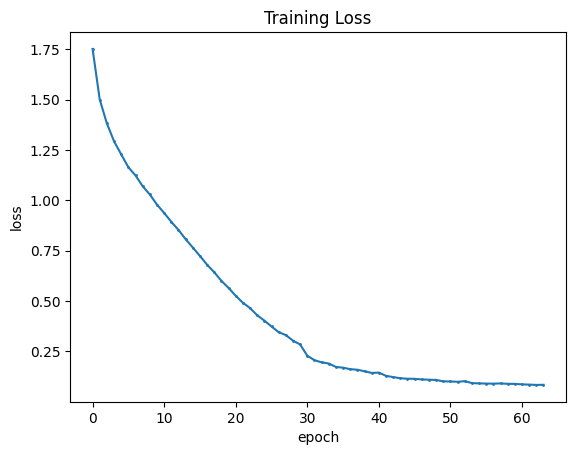

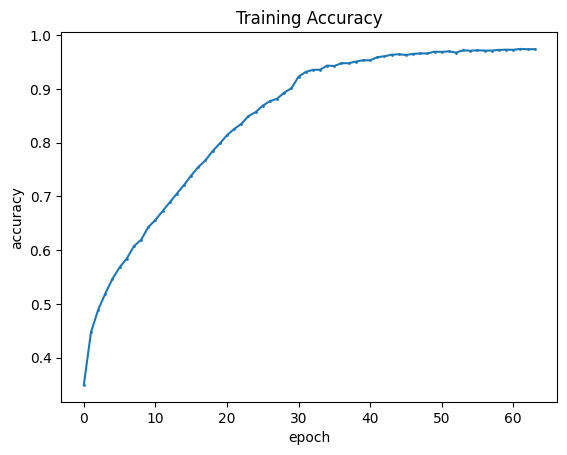

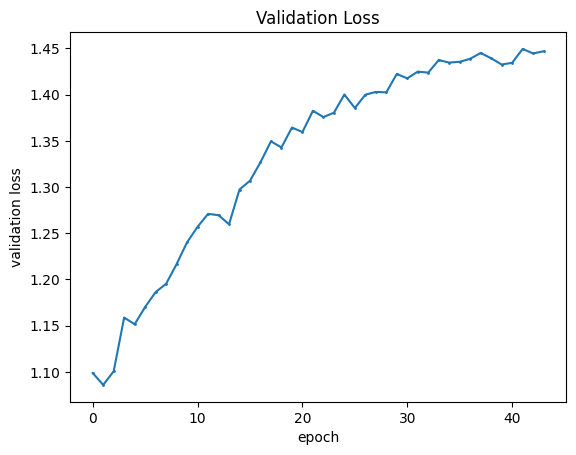

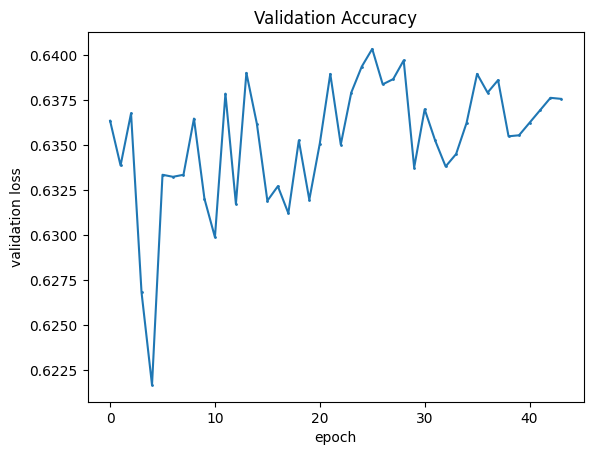

In [10]:
data = utility.read_pickle_files(m.record_save_path + '/loss_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="loss", title="Training Loss", 
                    save_path=m.record_save_path+"/loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/accuracy_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="accuracy", title="Training Accuracy", 
                    save_path=m.record_save_path+"/accuracy_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_loss_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="validation loss", 
                    title="Validation Loss", save_path=m.record_save_path+"/val_loss_history.png")

data = utility.read_pickle_files(m.record_save_path + '/val_accuracy_history.pkl')
utility.plot_record(x=range(len(data)), y=data, xlabel="epoch", ylabel="validation accuracy", 
                    title="Validation Accuracy", save_path=m.record_save_path+"/val_accuracy_history.png")

In [11]:
# evaluate model
model = m.EmotionCNN(num_classes=7)
utility.model_validation(model, device, test_loader, m.pth_save_path)
utility.model_validation(model, device, test_loader, m.pth_manual_save_path)

Test Accuracy: 63.83393702981332%
Test Accuracy: 63.83393702981332%


Test Accuracy: 63.83393702981332%
              precision    recall  f1-score   support

           0       0.54      0.53      0.54       958
           1       0.86      0.54      0.66       111
           2       0.54      0.44      0.48      1024
           3       0.83      0.83      0.83      1774
           4       0.56      0.63      0.60      1233
           5       0.50      0.52      0.51      1247
           6       0.77      0.78      0.78       831

    accuracy                           0.64      7178
   macro avg       0.66      0.61      0.63      7178
weighted avg       0.64      0.64      0.64      7178


<Figure size 700x700 with 0 Axes>

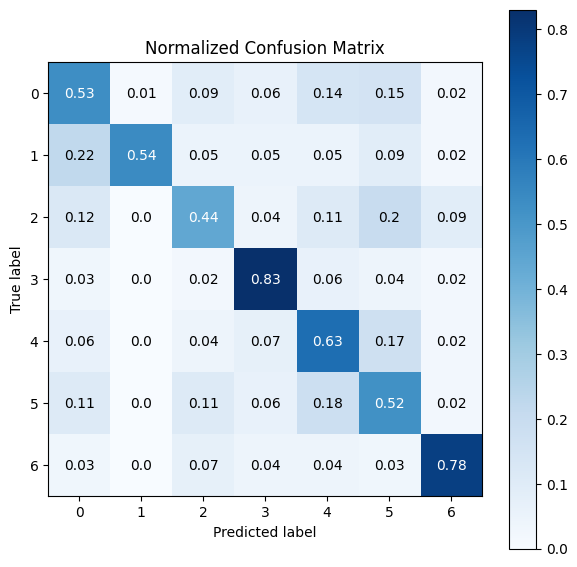

In [12]:
model.eval()

correct = 0
total = 0
# for confusion matrix
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)  # predicted is the emotion index
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # for confusion matrix
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

# calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# plot confusion matrix
plt.figure(figsize=(7, 7))
skplt.metrics.plot_confusion_matrix(
    y_true, y_pred, figsize=(7, 7), normalize=True)
plt.savefig(m.record_save_path+"/confusion_matrix_model3.png")

# print classification report
print(classification_report(y_true, y_pred))